In [3]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import pandas.util.testing as tm

In [12]:
df = pd.read_csv("train.csv")
df.head()

,Id,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,...,3,0,12,2,11,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,...,3,2,7,2,3,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,...,3,0,12,3,9,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,...,3,0,18,2,7,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,...,3,1,10,2,10,7,7,8,1,1


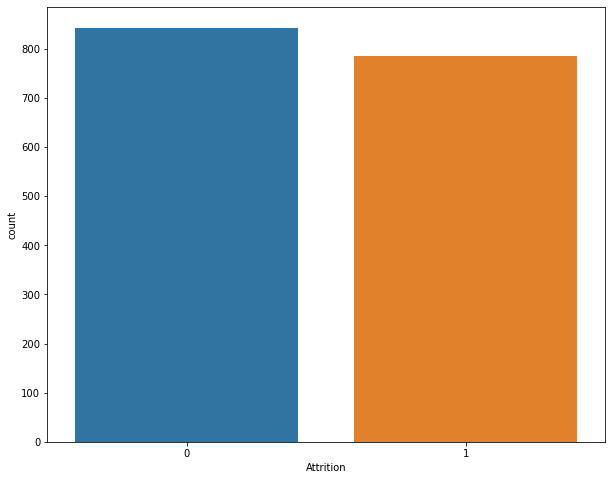

In [13]:
plt.subplots(figsize=(10,8))
ax = sns.countplot(x="Attrition", data=df)

In [14]:
# Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

df = pd.get_dummies(df, prefix_sep=" ",columns=object_cols)
feats_to_scale = df.drop(['BusinessTravel Travel_Rarely','Department Sales','EducationField Technical Degree', 'Gender Male','JobRole Sales Representative','MaritalStatus Single','OverTime Yes'], axis=1)

In [15]:
# Initialize StandardScaler
scaler = preprocessing.StandardScaler()


# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))

# Update the dataset with the new standerdized features
scaled_df = df.copy()
scaled_df.update(scaled_features)


In [16]:
X = scaled_df.drop(["Attrition"], axis=1)
y = scaled_df["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)

In [18]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train, rename=False):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["Attrition"] = labels.to_numpy()
    
    if rename:
        df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
        
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, rename=True)

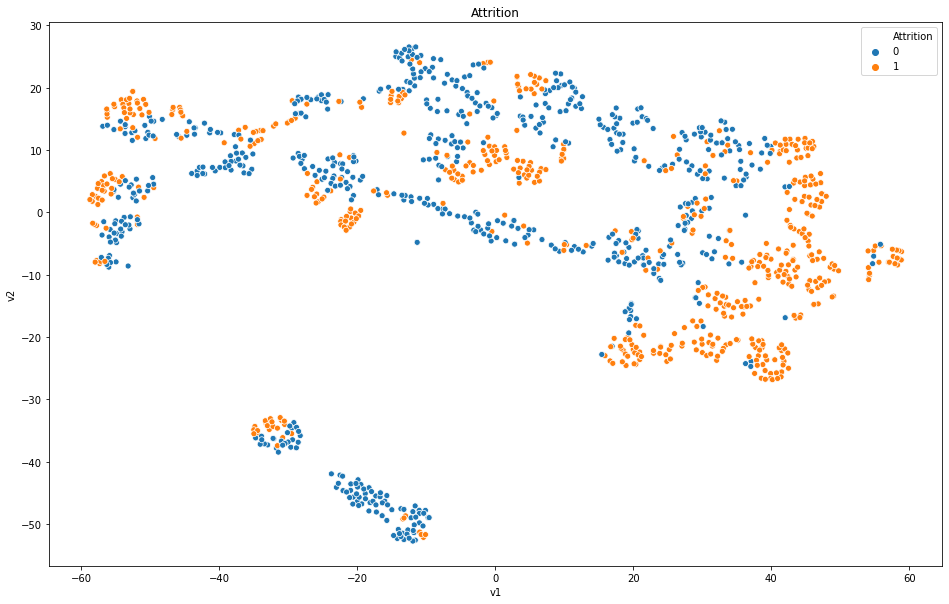

In [19]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="Attrition", data=plotting_data_embedded)
ax.set(title = "Attrition")
plt.show()

In [36]:
model = Sequential()

model.add(Dense(200, input_shape=(49,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

In [37]:
INIT_LR = 0.001
NUM_EPOCHS = 30
BS = 64
opt = RMSprop(lr = INIT_LR)

# This is just a necessary step to compile the model, we don't actually need it because we're not using the old model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Reduce the learning rate by half if validation accuracy has not increased in the last 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

fitted_network = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=30, callbacks=[learning_rate_reduction])

Train on 976 samples, validate on 245 samples
Epoch 1/30
976/976 [==============================] - 3s 3ms/step - loss: 0.6675 - accuracy: 0.6527 - val_loss: 0.6184 - val_accuracy: 0.7224
Epoch 2/30
976/976 [==============================] - 0s 132us/step - loss: 0.5349 - accuracy: 0.7449 - val_loss: 0.7966 - val_accuracy: 0.7102
Epoch 3/30
976/976 [==============================] - 0s 99us/step - loss: 0.4616 - accuracy: 0.7889 - val_loss: 0.5238 - val_accuracy: 0.7633
Epoch 4/30
976/976 [==============================] - 0s 106us/step - loss: 0.4391 - accuracy: 0.8268 - val_loss: 0.4875 - val_accuracy: 0.8041
Epoch 5/30
976/976 [==============================] - 0s 123us/step - loss: 0.4410 - accuracy: 0.8227 - val_loss: 0.3755 - val_accuracy: 0.8245
Epoch 6/30
976/976 [==============================] - 0s 147us/step - loss: 0.4157 - accuracy: 0.8402 - val_loss: 0.3595 - val_accuracy: 0.8286
Epoch 7/30
976/976 [==============================] - 0s 102us/step - loss: 0.4073 - accuracy

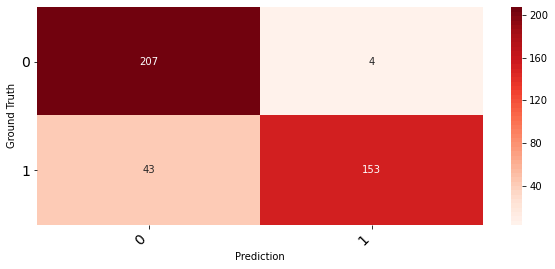

Accuray: 88.452%
ROC-AUC: 0.88083
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       211
           1       0.97      0.78      0.87       196

    accuracy                           0.88       407
   macro avg       0.90      0.88      0.88       407
weighted avg       0.90      0.88      0.88       407



In [38]:
# predict results
preds = np.round(model.predict(X_test)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

In [39]:
dtest = pd.read_csv("test.csv")
dtest = pd.get_dummies(dtest, prefix_sep=" ",columns=object_cols)
feats_to_scale = dtest.drop(['BusinessTravel Travel_Rarely','Department Sales','EducationField Technical Degree', 'Gender Male','JobRole Sales Representative','MaritalStatus Single','OverTime Yes'], axis=1)

In [40]:
# Initialize StandardScaler
scaler = preprocessing.StandardScaler()


# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))

# Update the dataset with the new standerdized features
scaled_test = dtest.copy()
scaled_test.update(scaled_features)

In [41]:
a=model.predict(scaled_test)
b=a[:]
ss=sample_submission.drop('Attrition',axis=1)
ss['Attrition']=b
ss.to_csv('submissionnew.csv',index=False)
ss.tail()



,Id,Attrition
465,466,0.495525
466,467,0.264059
467,468,0.207084
468,469,0.095546
469,470,0.104743


In [42]:
sample_submission = pd.read_csv('Sample_submission.csv')
sample_submission.head()

,Id,Attrition
0,1,0.742476
1,2,0.347438
2,3,0.938753
3,4,0.456471
4,5,0.363193
